In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
url_pca = "https://raw.githubusercontent.com/ricki0313/Pattern_Recognition_final_project_2025/refs/heads/main/W2_Data%20standardization%2C%20dimensionality%20reduction/pca_3d_features.csv"
df_pca = pd.read_csv(url_pca)
df_pca.head(3)


,Customer ID,PC1,PC2,PC3
0,12346.0,6.682060,54.061766,-10.740796
1,12347.0,0.881733,-0.362321,-0.021707
2,12348.0,-0.238705,0.028543,0.027791


<h3> Silhouette Score with PCA

In [3]:
X_pca = df_pca[['PC1', 'PC2', 'PC3']].values
K_range = range(2, 11)

In [4]:
sil_score = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    sil_score.append(score)
print(sil_score)

[0.9318321253140416, 0.9242403266859931, 0.9249990078719216, 0.5627763718985047, 0.5101542046144919, 0.5139908623041232, 0.5178582573651515, 0.5203177769290809, 0.5198249652835583]


平均 Silhouette 分數顯示：K = 2（0.932）與 K = 3（0.924）皆具有極高的群集品質，代表資料在 PCA 三維空間中呈現非常清楚的分群結構。

從 K = 4 起分數大幅下降（由 0.92 降至 0.56），顯示超過三群後的分群會切割原本緊密的資料團塊，導致群內密度降低、群間分離度也變差，因此 K ≥ 4 並不適合作為資料的自然分群數。

綜合數據表現與資料的可解釋性，K = 3 不僅提供接近最佳的 Silhouette 分數，也能對應到三種有明確行為差異的客戶族群（一般客戶、高價值客戶、批發型客戶）。
因此，本研究採用 K = 3 作為最終分群數。

<h3> K-means (set k = 3) & visualization with PCA

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
labels = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_

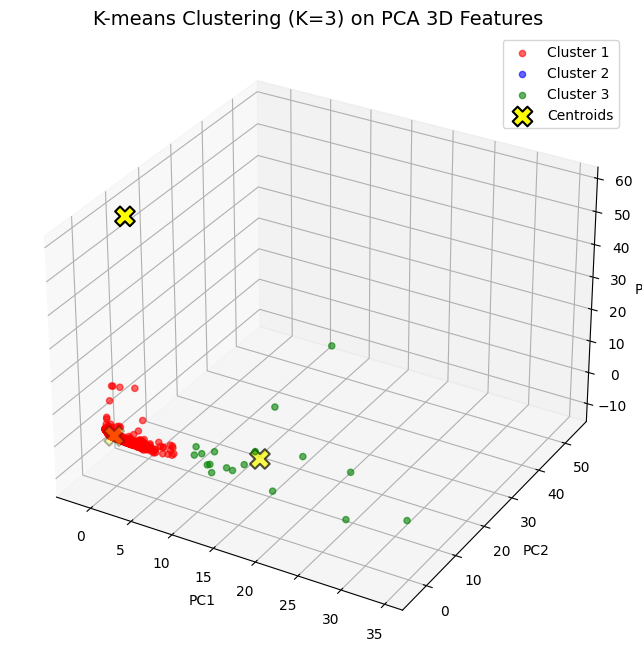

In [12]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")

colors = ["red", "blue", "green"]

for k in range(3):
    cluster_points = X_pca[labels == k]
    ax.scatter(
        cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
        s=20, alpha=0.6, color=colors[k], label=f'Cluster {k+1}'
    )

ax.scatter(
    centroids[:, 0], centroids[:, 1], centroids[:, 2],
    s=200,
    color='yellow',
    edgecolor='black',
    linewidth=1.5,
        marker='X',
    zorder=100,
    label='Centroids'
)

ax.set_title('K-means Clustering (K=3) on PCA 3D Features', fontsize=14)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()

plt.show()

In [13]:
df_pca["cluster"] = labels
df_pca.head(3)

,Customer ID,PC1,PC2,PC3,cluster
0,12346.0,6.682060,54.061766,-10.740796,2
1,12347.0,0.881733,-0.362321,-0.021707,0
2,12348.0,-0.238705,0.028543,0.027791,0


<h3> statistical values of each cluster

In [14]:
url_feat = "https://raw.githubusercontent.com/ricki0313/Pattern_Recognition_final_project_2025/refs/heads/main/W1_Data%20cleaning%2C%20aggregation%2C%20visualization/customer_features.csv"
df_feat = pd.read_csv(url_feat)
df_feat.head(3)

,Customer ID,Recency,Frequency,Monetary,AvgUnitPrice,UniqueItems,AvgQuantPerOrder
0,12346.0,326,1,77183.60,1.040000,1,74215.000000
1,12347.0,2,7,4310.00,2.644011,103,13.505495
2,12348.0,75,4,1797.24,5.764839,22,75.516129


In [15]:
df_pca["cluster"] = labels
df_pca.head(3)

,Customer ID,PC1,PC2,PC3,cluster
0,12346.0,6.682060,54.061766,-10.740796,2
1,12347.0,0.881733,-0.362321,-0.021707,0
2,12348.0,-0.238705,0.028543,0.027791,0


In [16]:
df_feat = df_feat.merge(df_pca[["Customer ID", "cluster"]], on="Customer ID", how="inner")
df_feat.head(3)

,Customer ID,Recency,Frequency,Monetary,AvgUnitPrice,UniqueItems,AvgQuantPerOrder,cluster
0,12346.0,326,1,77183.60,1.040000,1,74215.000000,2
1,12347.0,2,7,4310.00,2.644011,103,13.505495,0
2,12348.0,75,4,1797.24,5.764839,22,75.516129,0


In [17]:
feature_cols = ['Recency','Frequency','Monetary','AvgUnitPrice','UniqueItems','AvgQuantPerOrder']

In [18]:
df_feat["cluster"].value_counts()

cluster
0    4320
2      18
1       1
Name: count, dtype: int64

PCA 降維後進行 K-means 雖然在 Silhouette Score 上獲得高分，但實際分群結果嚴重不均衡（4321 / 17 / 1），顯示 PCA 壓縮了部分客戶行為資訊，使中間群體的變異被過度壓縮，進而使 K-means 難以辨識自然客群。最終產生的群集缺乏可解釋性，也不符合真實商業語意，因此不適合作為最終的客戶分群模型。